In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from tqdm import tqdm
import os

RSEED = 42

In [2]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

MODEL_DIR = Path.cwd()

In [3]:
def replace_nan(x):
    if x=="nan":
        return np.nan
    else :
        return float(x)

def convert_str_to_list(data, features):
    for feature in features : 
        data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.strip('[]').split(",")])
    return data

## Data cleaning 

In [4]:
# read dataset from csv file
df = pd.read_csv(DATA_DIR / "dataset_long_all_feat_with_radiation.csv", parse_dates=["date"])
df = convert_str_to_list(df, ['temp', 'wind', 'radiation'])
# add day of the year as additional feature
df['dayofyear'] = df['date'].dt.dayofyear
df.head()

,uid,latitude,longitude,date,split,region,severity,density,image_src,lake_size,...,mean_s,mean_v,temp,wind,elev_mean,elev_median,elev_min,elev_max,radiation,dayofyear
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1.0,585.0,NaN,2578.0,...,0.234153,0.607841,"[286.6784, 286.74725, 286.69934, 286.7568, 286...","[2.2833447, 1.94622, 1.331817, 1.2656376, 2.75...",0.058860,0.057391,0.057125,0.068623,"[0.0, 994.0, 948.0, 0.0, 391.0, 905.0, 0.0, 96...",134
1,aabn,36.559700,-121.510000,2016-08-31,test,NaN,NaN,NaN,no_image,NaN,...,NaN,NaN,"[nan, nan, 286.99545, nan, nan, nan, 288.10834...","[nan, nan, 3.9813075, nan, nan, nan, 3.7734618...",0.028844,0.028692,0.028140,0.031199,"[nan, 565.0, nan, nan, 781.0, 809.0, 265.6, 59...",244
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1.0,290.0,NaN,176.0,...,0.503357,0.115065,"[290.66895, 286.5667, 285.7143, 291.8991, 285....","[2.005445, 3.5083356, 2.3487167, 2.2689152, 1....",0.044726,0.044747,0.039996,0.048706,"[0.0, 380.8, 393.0, 0.0, 558.1, 492.2, 0.0, 11...",324
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1.0,1614.0,NaN,NaN,...,NaN,NaN,"[301.63077, nan, nan, 314.93414, 301.9608, 297...","[1.5693433, nan, nan, 6.309602, 1.4112688, 2.9...",0.050598,0.050579,0.043481,0.056447,"[0.0, 473.0, 875.0, 0.0, 938.0, 868.0, 0.0, 80...",237
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3.0,111825.0,NaN,1495.0,...,0.480389,0.085137,"[306.29938, 298.71417, 300.36365, 315.71246, 3...","[7.8561816, 6.940431, 7.351467, 10.175036, 9.9...",0.174059,0.173836,0.171177,0.178763,"[129.4, 975.0, 990.0, 128.7, 972.0, 987.0, 129...",204


In [5]:
# use only data points after 2014-10-07 because of missing weather data
#df = df[df['date'] > datetime.datetime(2014,10,7)]

# reduce dataset to only datapoints where images were found
#df = df[df['image_src'] != 'no_image']

In [6]:
# only 6176 datapoints contain image features (there are no images for the others)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23533 entries, 0 to 23532
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uid          23533 non-null  object        
 1   latitude     23533 non-null  float64       
 2   longitude    23533 non-null  float64       
 3   date         23533 non-null  datetime64[ns]
 4   split        23533 non-null  object        
 5   region       17053 non-null  object        
 6   severity     17053 non-null  float64       
 7   density      17053 non-null  float64       
 8   image_src    6480 non-null   object        
 9   lake_size    9086 non-null   float64       
 10  mean_r       9086 non-null   float64       
 11  mean_g       9086 non-null   float64       
 12  mean_b       9086 non-null   float64       
 13  mean_ir      9086 non-null   float64       
 14  mean_h       9086 non-null   float64       
 15  mean_s       9086 non-null   float64       
 16  mean

## Modeling
### Data Cleaning and aggregation

In [7]:
df.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'region', 'severity',
       'density', 'image_src', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
       'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'temp', 'wind', 'elev_mean',
       'elev_median', 'elev_min', 'elev_max', 'radiation', 'dayofyear'],
      dtype='object')

In [8]:
example_row = df[df.uid == "garm"].iloc[0]

# drop one extreme outlier
#outlier = df[df.uid == "lvtt"].iloc[0]
df = df.drop(df.loc[df['uid']=='lvtt'].index)

df = df.reset_index(drop=True)

In [9]:
# this takes 2min 58sec to execute:

# # calculate daily mean values for temperature and wind
# days = range(7)
# for row in (pbar := tqdm(df.itertuples(), total=len(df))):
#     for day in days:
#         # get daily wind means
#         mean_wind = np.nanmean([row.wind[4*(day+1)-4], 
#                                 row.wind[4*(day+1)-3], 
#                                 row.wind[4*(day+1)-2], 
#                                 row.wind[4*(day+1)-1]])
#         df.loc[df['uid'] == row.uid, [f'wind_mean_{day+1}']] = mean_wind
#         # get daily temp means
#         mean_temp = np.nanmean([row.temp[4*(day+1)-4],
#                                 row.temp[4*(day+1)-3], 
#                                 row.temp[4*(day+1)-2], 
#                                 row.temp[4*(day+1)-1]])
#         df.loc[df['uid'] == row.uid, [f'temp_mean_{day+1}']] = mean_temp

In [10]:
# this takes 3.8sec to execute:

# function to calculate daily mean values from a time series with 4 values per day
def get_daily_means(time_series, num_daily_values=4):
    length = len(time_series)//num_daily_values
    means = np.zeros(length)
    for i in range(length):
        means[i] = np.nanmean(time_series[i * num_daily_values : (i+1) * num_daily_values])
    return means

# calculate daily means for all weather features and add them as 
# new columns to the dataframe.
weather_feats = ['temp', 'wind']
for feat in weather_feats:
    df[f'{feat}_daily'] = df[feat].apply(get_daily_means)
    df_new = df[f'{feat}_daily'].apply(pd.Series)
    df_new.columns = [f'{feat}_mean_{i+1}' for i in range(7)]
    df = df.merge(df_new, left_index=True, right_index=True, how='inner')
    df = df.drop(f'{feat}_daily', axis=1)

/var/folders/x6/y83h9zms7bq9mpq4000kg4tc0000gn/T/ipykernel_64434/2443253084.py:8: RuntimeWarning: Mean of empty slice
  means[i] = np.nanmean(time_series[i * num_daily_values : (i+1) * num_daily_values])


In [11]:
df.head()

,uid,latitude,longitude,date,split,region,severity,density,image_src,lake_size,...,temp_mean_5,temp_mean_6,temp_mean_7,wind_mean_1,wind_mean_2,wind_mean_3,wind_mean_4,wind_mean_5,wind_mean_6,wind_mean_7
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1.0,585.0,NaN,2578.0,...,287.278008,287.331322,287.371427,1.706755,3.075927,4.024818,2.873090,4.981789,3.556102,3.439010
1,aabn,36.559700,-121.510000,2016-08-31,test,NaN,NaN,NaN,no_image,NaN,...,289.843597,294.425150,288.715330,3.981308,5.110902,5.348507,4.948948,5.554672,5.447538,4.470411
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1.0,290.0,NaN,176.0,...,281.520655,279.392285,277.597368,2.532853,1.657363,2.778842,2.605776,3.004587,2.302050,1.371255
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1.0,1614.0,NaN,NaN,...,301.466250,293.931750,296.775000,3.939473,1.808803,2.279739,4.535705,4.829182,1.861201,1.717719
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3.0,111825.0,NaN,1495.0,...,304.939147,300.523025,298.255080,8.080779,8.766938,8.050130,8.660211,5.739048,5.417003,2.800415


In [12]:
# mean temperature and wind over the whole time (7 days)
df['temp_mean'] = df["temp"].apply(np.nanmean)
df['wind_mean'] = df["wind"].apply(np.nanmean)
df['rad_mean'] = df["radiation"].apply(np.nanmean)

/Users/markus/neuefische/tick-tick-bloom/.venv/lib/python3.9/site-packages/pandas/core/apply.py:1098: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(


In [13]:
df.columns

Index(['uid', 'latitude', 'longitude', 'date', 'split', 'region', 'severity',
       'density', 'image_src', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
       'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'temp', 'wind', 'elev_mean',
       'elev_median', 'elev_min', 'elev_max', 'radiation', 'dayofyear',
       'temp_mean_1', 'temp_mean_2', 'temp_mean_3', 'temp_mean_4',
       'temp_mean_5', 'temp_mean_6', 'temp_mean_7', 'wind_mean_1',
       'wind_mean_2', 'wind_mean_3', 'wind_mean_4', 'wind_mean_5',
       'wind_mean_6', 'wind_mean_7', 'temp_mean', 'wind_mean', 'rad_mean'],
      dtype='object')

In [14]:
# all of the features are numerical

# features = ['latitude', 'longitude', 'lake_size', 'mean_r', 'mean_g', 'mean_b',
#        'mean_ir', 'mean_h', 'mean_s', 'mean_v', 'elev_mean',
#        'elev_median', 'elev_min', 'elev_max', 'dayofyear', 'wind_mean_1',
#        'temp_mean_1', 'wind_mean_2', 'temp_mean_2', 'wind_mean_3',
#        'temp_mean_3', 'wind_mean_4', 'temp_mean_4', 'wind_mean_5',
#        'temp_mean_5', 'wind_mean_6', 'temp_mean_6', 'wind_mean_7',
#        'temp_mean_7', 'temp_mean', 'wind_mean', 'rad_mean']

features = ['latitude', 'longitude', 'lake_size', 'mean_ir', 'mean_h', 'elev_mean', 
            'dayofyear', 'temp_mean', 'wind_mean', 'rad_mean']

#features = ['lake_size', 'mean_ir', 'mean_h', 'elev_mean', 'temp_mean', 'wind_mean']

In [15]:
df[features]

,latitude,longitude,lake_size,mean_ir,mean_h,elev_mean,dayofyear,temp_mean,wind_mean,rad_mean
0,39.080319,-86.430867,2578.0,0.424409,0.413782,0.058860,134,287.095532,3.379642,497.380952
1,36.559700,-121.510000,NaN,NaN,NaN,0.028844,244,292.370221,5.110660,637.363100
2,35.875083,-78.878434,176.0,0.059888,0.163396,0.044726,324,283.980500,2.321818,300.347619
3,35.487000,-79.062133,NaN,NaN,NaN,0.050598,237,301.782546,3.098980,400.500000
4,38.049471,-99.827001,1495.0,0.020998,0.245394,0.174059,204,304.010039,6.787789,689.352381
...,...,...,...,...,...,...,...,...,...,...
23527,36.708500,-121.749000,NaN,NaN,NaN,0.023269,336,286.014273,2.237384,253.435000
23528,39.792190,-99.971050,8804.0,0.051426,0.336928,0.173784,170,291.637065,4.246976,706.742857
23529,35.794000,-79.012551,NaN,NaN,NaN,0.035874,83,286.046483,3.574775,482.666667
23530,35.742000,-79.238600,65.0,0.145229,0.126315,0.056300,326,282.058815,2.373771,310.750000


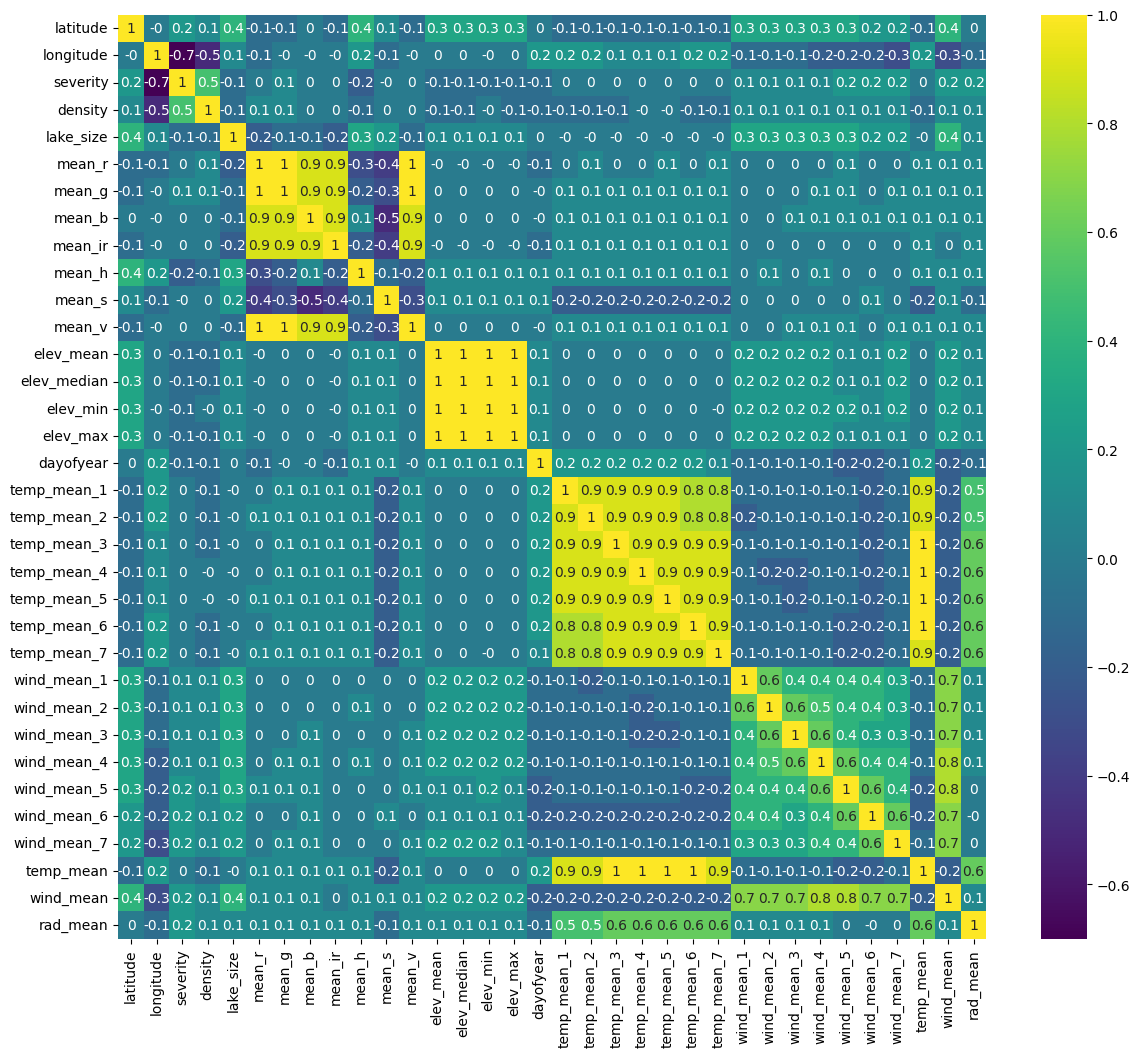

In [16]:
# Plot correlation matrix 
mask = np.triu(df.corr())
plt.figure(figsize = (14,12))
ax = sns.heatmap(round(df.corr(), 1)
                 ,annot=True
                 #,mask=mask
                 ,cmap='viridis')

### train test split

In [19]:
#X = df[features]
#y = df['severity'] - 1
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RSEED)

X_train = df[df['split'] == 'train'][features]
X_test = df[df['split'] == 'test'][features]
y_train = df[df['split'] == 'train']['severity'] - 1

### Imputing missing values

In [23]:
df[features].isna().sum()

latitude         0
longitude        0
lake_size    14446
mean_ir      14446
mean_h       14446
elev_mean        0
dayofyear        0
temp_mean     3257
wind_mean     3257
rad_mean      3261
dtype: int64

In [24]:
# impute missing values with mean values of train dataset
for feature in features:
    mean = np.nanmean(X_train[feature])
    X_train[feature].fillna(mean, inplace=True)
    X_test[feature].fillna(mean, inplace=True)

### Normalization

In [25]:
# normalize features (esp. 'latitude', 'longitude', 'lake_size', 'dayofyear')
scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

### (small) Baseline model

In [26]:
# Baseline model is just using one feature: 'longitude'
# EDA says longitude has strongest correlation with bacteria density
log_reg = LogisticRegression()
log_reg.fit(X_train[['longitude']], y_train)

LogisticRegression()

In [27]:
log_reg.intercept_

array([ 1.55942823,  0.9172398 ,  1.00068683, -0.5234662 , -2.95388867])

<AxesSubplot:xlabel='longitude', ylabel='severity'>

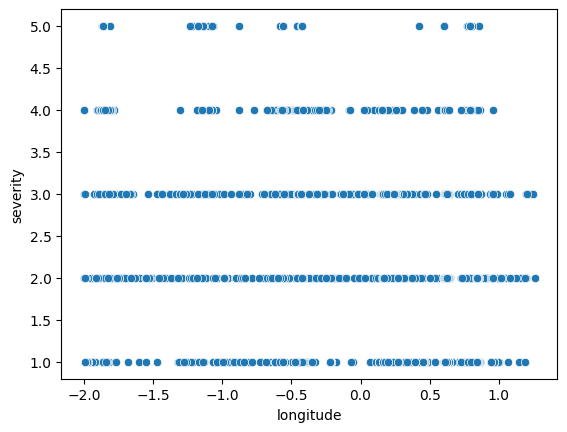

In [29]:
# plot datapoints for mean wind speed and the baseline model
sns.scatterplot(x=X_train['longitude'], y=(y_train+1))

### We need mooore models!!!

In [30]:
def train_predict_evaluate(model, X_train, y_train, X_test):
    """Train model, make prediction and evaluate

    Args:
        model (_type_): Regressor model
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
    """
    # train model
    model.fit(X_train, y_train)

    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(model)}") 
    print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    #print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    print('-----------------------------')

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
model_dectree     = DecisionTreeClassifier(max_features=6, max_depth=20, criterion='gini', random_state=RSEED)
model_adaboost    = AdaBoostClassifier(random_state=RSEED)
model_svc         = SVC()
model_sgdc        = SGDClassifier(random_state=RSEED)
model_rfc         = RandomForestClassifier(random_state=RSEED)
model_knc         = KNeighborsClassifier()
model_xgbc        = XGBClassifier()

models = [model_dectree, model_adaboost, model_svc, model_sgdc, model_rfc, model_knc, model_xgbc]

for model in tqdm(models):
    train_predict_evaluate(model, X_train, y_train, X_test)

 14%|█▍        | 1/7 [00:00<00:00,  9.30it/s]

Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
RMSE on train data: 0.476826340649044
-----------------------------


 29%|██▊       | 2/7 [00:00<00:02,  2.19it/s]

Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
RMSE on train data: 0.8931280377226782
-----------------------------


 57%|█████▋    | 4/7 [00:14<00:11,  3.86s/it]

Model: <class 'sklearn.svm._classes.SVC'>
RMSE on train data: 0.8512385589322159
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
RMSE on train data: 1.004271898196827
-----------------------------


 71%|███████▏  | 5/7 [00:16<00:06,  3.48s/it]

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
RMSE on train data: 0.021659944102254382
-----------------------------


 86%|████████▌ | 6/7 [00:17<00:02,  2.55s/it]

Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
RMSE on train data: 0.7383865096134744
-----------------------------


100%|██████████| 7/7 [00:20<00:00,  2.98s/it]

Model: <class 'xgboost.sklearn.XGBClassifier'>
RMSE on train data: 0.5983498302436198
-----------------------------


## Hyperparameter tuning (with the best types of models)

In [33]:
def grid_search_evaluate(model, hyperparameters, X_train, y_train, X_test):
    """make grid search for model parameters, get the best estimator, make prediction and evaluate

    Args:
        model (_type_): Regressor model
        hyperparameters (_type_): parameter list for the grid search
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
    """
    
    gs = GridSearchCV(model, hyperparameters, n_jobs=-1, scoring='accuracy', cv=3, verbose = 0)

    # Fit the grid search object to the training data and find the optimal parameters
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_

    # make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(best_model)}") 
    print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    #print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    print('-----------------------------')

    return best_model

In [34]:
model_sgdc = SGDClassifier(random_state=RSEED)
model_svc  = SVC()
model_rfc  = RandomForestClassifier(random_state=RSEED)
model_knc  = KNeighborsClassifier()
model_xgbc = XGBClassifier()

models = [model_sgdc, model_svc, model_rfc, model_knc, model_xgbc]

# parameter lists for tuning
parameters_sgdc = {
                'eta0': [0.01, 0.1],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],                
                'max_iter':[500, 1000, 2000]
                } 
parameters_svc = {
                'class_weight': ['balanced', None],
                'C': [0.9, 1.0, 1.1],
                'degree': [2, 3, 4, 5]
                } 
parameters_rfc = {
                'n_estimators':[90, 95, 100],                
                'max_features':[10, 8, 7, 6],               
                'max_depth' : [35, 100], 
                'min_samples_split': [2,4,6]
                } 
parameters_knc = {
                'n_neighbors':[5, 10, 15],                
                'metric':['euclidean', 'manhattan'],               
                'weights':['uniform', 'distance'],                         
                } 
parameters_xgbc = {
                'eta': [0.1, 0.3, 0.5],
                'max_depth': [4, 6, 8],
                'eval_metric': [accuracy_score]
                }

params = [parameters_sgdc, parameters_svc, parameters_rfc, parameters_knc, parameters_xgbc]

best_models = []
for model, param in zip(tqdm(models), params):
    best_models.append(grid_search_evaluate(model, param, X_train, y_train, X_test))

for model in best_models:
    print(model, '\n', model.get_params(), '\n')


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

Model: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
RMSE on train data: 0.9947964545199207
-----------------------------


 40%|████      | 2/5 [01:29<02:35, 51.92s/it]

Model: <class 'sklearn.svm._classes.SVC'>
RMSE on train data: 0.8496180372904244
-----------------------------


 60%|██████    | 3/5 [04:39<03:50, 115.08s/it]

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
RMSE on train data: 0.3882964109344124
-----------------------------


/Users/markus/neuefische/tick-tick-bloom/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/markus/neuefische/tick-tick-bloom/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be elimina

Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
RMSE on train data: 0.8086298550957621
-----------------------------


100%|██████████| 5/5 [05:24<00:00, 64.99s/it]

Model: <class 'xgboost.sklearn.XGBClassifier'>
RMSE on train data: 0.7222462809588585
-----------------------------
SGDClassifier(eta0=0.1, learning_rate='invscaling', max_iter=500,
              random_state=42) 
 {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.1, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'hinge', 'max_iter': 500, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

SVC(C=1.1, degree=2) 
 {'C': 1.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False} 

RandomForestClassifier(max_depth=100, max_features=7, min_samples_split=6,

### Test the model

In [35]:
best_model = best_models[2]

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test) + 1 # offset correction for submission

print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
#print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")

RMSE on train data: 0.3882964109344124


### create submission file

In [71]:
errored_ids = ['alwh', 'bslg', 'dbci', 'egjs', 'eqkm', 'gwei', 'gygq', 'hdvw', 
                'hhlw', 'hklc', 'hsqr', 'ifel', 'ifwc', 'jdvp', 'jmvw', 'juny',
                'jztb', 'ljln', 'msjt', 'nttf', 'nyul', 'oesl', 'ojsc', 'oomm',
                'prpz', 'qken', 'qpeh', 'rygl', 'ugqe', 'uhfr', 'ushn', 'vblk',
                'wrqa', 'wvkh', 'wzxe', 'einx', 'tgiq']

In [77]:
submission = pd.read_csv(DATA_DIR / 'submission_format.csv')

# create dataframe that does not contain errored ids (because our 
# prediction array also does not contain them)
df_s = submission.copy()
for id in errored_ids:
    df_s.drop(df_s.loc[df_s['uid']==id].index, inplace=True)
# write predictions into dataframe
df_s['severity'] = y_test_pred.astype(int)
df_s.head()

,uid,region,severity
0,aabn,west,4
1,aair,west,3
2,aajw,northeast,1
3,aalr,midwest,4
4,aalw,west,3


In [78]:
# merge into submission dataframe and replace NaNs (from error ids) with severity class 1
submission = submission.drop('severity', axis=1).merge(df_s[['uid', 'severity']], on='uid', how='outer').fillna(1)
# ensure correct datatypes
submission = submission.astype({'severity': int})
submission.head()

,uid,region,severity
0,aabn,west,4
1,aair,west,3
2,aajw,northeast,1
3,aalr,midwest,4
4,aalw,west,3


In [79]:
# write submission file
submission.to_csv(DATA_DIR / 'submission_1.csv', index=False)

# submission score 1.0479
# Rank 42 out of 1358 competitors